In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img1 = cv2.imread('view1.jpeg')
img2 = cv2.imread('view4.jpeg')

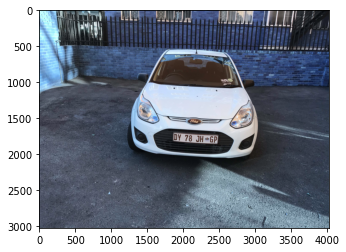

In [3]:
plt.imshow(img1)

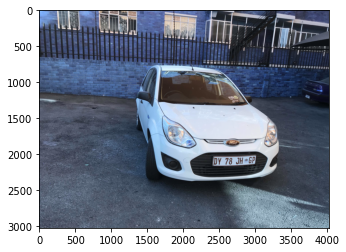

In [4]:
plt.imshow(img2)

In [5]:
gray_img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

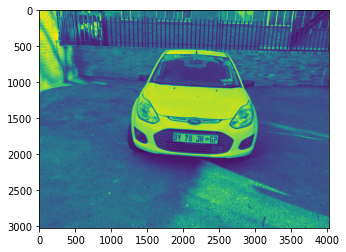

In [6]:
plt.imshow(gray_img1)

In [7]:
sobel_x = cv2.Sobel(gray_img1,cv2.CV_64F,1,0,ksize=5) 
sobel_y = cv2.Sobel(gray_img1,cv2.CV_64F,0,1,ksize=5)
scharr_x = cv2.Scharr(gray_img1,cv2.CV_64F,dx= 1,dy = 0,scale=1,borderType=cv2.BORDER_DEFAULT)
scharr_y = cv2.Scharr(gray_img1,cv2.CV_64F,0,1,borderType=cv2.BORDER_DEFAULT,scale=1)

In [8]:
# plt.imshow(sobel_y)

In [9]:
laplacian = cv2.Laplacian(gray_img1,cv2.CV_64F)
# plt.imshow(laplacian)

In [10]:
canny_1 =  cv2.Canny(gray_img1,20,170,L2gradient=False)
canny_2 =  cv2.Canny(gray_img1,20,170,L2gradient=True)

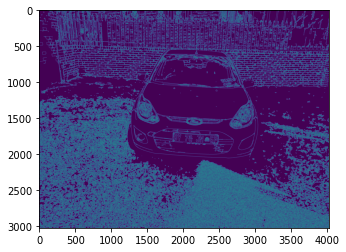

In [11]:
plt.imshow(canny_2)

In [5]:
from torchvision import models
from PIL import Image
import torch
import cv2

# Apply the transformations needed
import torchvision.transforms as T

# Define the helper function
def decode_segmap(image, source, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
   

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)

    # Load the foreground input image 
    foreground = cv2.imread(source)

    # Change the color of foreground image to RGB 
    # and resize image to match shape of R-band in RGB output map
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

    # Create a background array to hold white pixels
    # with the same size as RGB output map
    background = 255 * np.ones_like(rgb).astype(np.uint8)

    # Convert uint8 to float
    foreground = foreground.astype(float)
    background = background.astype(float)

    # Create a binary mask of the RGB output map using the threshold value 0
    th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

    # Apply a slight blur to the mask to soften edges
    alpha = cv2.GaussianBlur(alpha, (7,7),0)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255

    # Multiply the foreground with the alpha matte
    foreground = cv2.multiply(alpha, foreground)  
    
    # Multiply the background with ( 1 - alpha )
    background = cv2.multiply(1.0 - alpha, background)  
    
    # Add the masked foreground and background
    outImage = cv2.add(foreground, background)

    # Return a normalized output image for display
    return outImage/255

def segment(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(450), 
#                     T.CenterCrop(224), 
                    T.ToTensor(), 
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to()
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    
    rgb = decode_segmap(om, path)
    
    plt.imshow(rgb); plt.axis('off'); plt.show()

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

segment(dlab,r'C:\Users\Admin\Documents\Keshav\Programming\Open CV\Car Scan\view1.jpeg', show_orig=False)

AssertionError: Torch not compiled with CUDA enabled

In [3]:
print(torch.cuda.is_available())

False


In [13]:
# image_vec = cv2.imread('view1.jpeg', 1)
# g_blurred = cv2.GaussianBlur(image_vec, (5, 5), 0)

# blurred_float = g_blurred.astype(np.float32) / 255.0
# edgeDetector = cv2.ximgproc.createStructuredEdgeDetection("model.yml")
# edges = edgeDetector.detectEdges(blurred_float) * 255.0
# # cv2.imwrite('edge-raw.jpg', edges)

# def SaltPepperNoise(edgeImg):

#     count = 0
#     lastMedian = edgeImg
#     median = cv2.medianBlur(edgeImg, 3)
#     while not np.array_equal(lastMedian, median):
#         zeroed = np.invert(np.logical_and(median, edgeImg))
#         edgeImg[zeroed] = 0
#         count = count + 1
#         if count > 70:
#             break
#         lastMedian = median
#         median = cv2.medianBlur(edgeImg, 3)
# edges_ = np.asarray(edges, np.uint8)
# SaltPepperNoise(edges_)
# cv2.imwrite('edge.jpg', edges_)
# image_display('edge.jpg')


# def findSignificantContour(edgeImg):
#     image, contours, hierarchy = cv2.findContours(
#         edgeImg,
#         cv2.RETR_TREE,
#         cv2.CHAIN_APPROX_SIMPLE
#     )
#         # Find level 1 contours
#     level1Meta = []
#     for contourIndex, tupl in enumerate(hierarchy[0]):
#         # Filter the ones without parent
#         if tupl[3] == -1:
#             tupl = np.insert(tupl.copy(), 0, [contourIndex])
#             level1Meta.append(tupl)
# # From among them, find the contours with large surface area.
#     contoursWithArea = []
#     for tupl in level1Meta:
#         contourIndex = tupl[0]
#         contour = contours[contourIndex]
#         area = cv2.contourArea(contour)
#         contoursWithArea.append([contour, area, contourIndex])
#         contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
#         largestContour = contoursWithArea[0][0]
#     return largestContour
# contour = findSignificantContour(edges_u)
# # Draw the contour on the original image
# contourImg = np.copy(src)
# cv2.drawContours(contourImg, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
# cv2.imwrite('contour.jpg', contourImg)
# image_display('contour.jpg')

# mask = np.zeros_like(edges_u)
# cv2.fillPoly(mask, [contour], 255)
# # calculate sure foreground area by dilating the mask
# mapFg = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=10)
# # mark inital mask as "probably background"
# # and mapFg as sure foreground
# trimap = np.copy(mask)
# trimap[mask == 0] = cv2.GC_BGD
# trimap[mask == 255] = cv2.GC_PR_BGD
# trimap[mapFg == 255] = cv2.GC_FGD
# # visualize trimap
# trimap_print = np.copy(trimap)
# trimap_print[trimap_print == cv2.GC_PR_BGD] = 128
# trimap_print[trimap_print == cv2.GC_FGD] = 255
# cv2.imwrite('trimap.png', trimap_print)
# image_display('trimap.png')

In [7]:
# img = cv2.imread('view1.jpeg')

# # convert to graky
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # threshold input image as mask
# mask = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1]

# # negate mask
# mask = 255 - mask

# # apply morphology to remove isolated extraneous noise
# # use borderconstant of black since foreground touches the edges
# kernel = np.ones((3,3), np.uint8)
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# # anti-alias the mask -- blur then stretch
# # blur alpha channel
# mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)

# # linear stretch so that 127.5 goes to 0, but 255 stays 255
# mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

# # put mask into alpha channel
# result = img.copy()
# result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
# result[:, :, 3] = mask

# # save resulting masked image
# # cv2.imwrite('person_transp_bckgrnd.png', result)

# # display result, though it won't show transparency

# # plt.imshow(gray)
# # plt.show()
# # plt.imshow(mask)
# # plt.show()
# # plt.imshow(result)
# # plt.show()

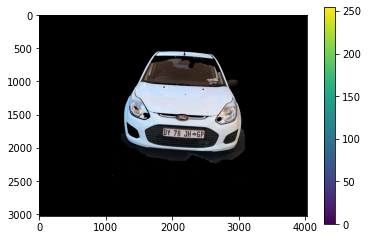

(<matplotlib.image.AxesImage at 0x25fc434dbb0>,
 None)

In [14]:
img = cv2.imread('view1.jpeg')
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (1100,500,2000,2000)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()

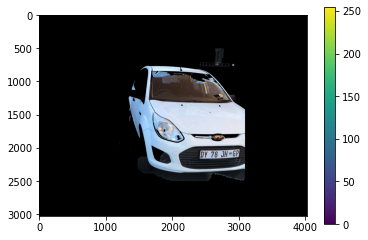

(<matplotlib.image.AxesImage at 0x25fc44d4a30>,
 None)

In [16]:
img = cv2.imread('view4.jpeg')
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (1100,500,2000,2000)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(img),plt.colorbar(),plt.show()